In [ ]:
#!/usr/bin/env python3
# Authors: Dinesh M, 
#          Ragothaman M. Yennamalli, SASTRA Deemed to be University
# Last Modified: 2025-05-11
# Description:
#  This python script applies traditional machine learning models for PANN classification in Tamil poetry.
#  It uses precomputed text embeddings as features and corresponding PANN labels as targets.
#  Models such as SVM, Random Forest, Logistic Regression, Naive Bayes, and K-Nearest Neighbors (KNN) are trained and evaluated.
#  Evaluation metrics like Accuracy, Precision, Recall, and F1-score are used to measure model performance.
#  using svm to predict the pann for the unclassified pazhurams.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import joblib

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

df = pd.read_excel("path_to_your_directory")

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()
    text = re.sub(r"[^ஂ-ஃஅ-஺ா-ூெ-ைொ-்0-9 ]", "", text) 
    text = re.sub(r"\s+", " ", text)
    return text

df["clean_song"] = df["song"].apply(preprocess_text)
df = df.dropna(subset=["clean_song", "pann"]).reset_index(drop=True)

label_encoder = LabelEncoder()
df["pann_label"] = label_encoder.fit_transform(df["pann"])

joblib.dump(label_encoder, "label_encoder.pkl")

pann_mapping = dict(zip(df["pann"], df["pann_label"]))
print("\n PANN to Numeric Label Mapping:")
for pann, label in pann_mapping.items():
    print(f"{pann} → {label}")

def get_avg_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
    tokens = {key: value.to(device) for key, value in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)

    embeddings = outputs.last_hidden_state.squeeze(0)
    attention_mask = tokens["attention_mask"].squeeze(0)

    valid_embeddings = embeddings[attention_mask.bool()]
    avg_embedding = valid_embeddings.mean(dim=0).cpu().numpy().tolist()
    return avg_embedding

print("\n Extracting averaged BERT embeddings...\n")
embeddings = []
for text, pann_label in tqdm(zip(df["clean_song"], df["pann_label"]), total=len(df)):
    avg_embedding = get_avg_bert_embedding(text)
    embeddings.append((avg_embedding, pann_label))

embedding_df = pd.DataFrame(embeddings, columns=["Embedding", "PANN_LABEL"])
embedding_df["Embedding"] = embedding_df["Embedding"].apply(lambda x: str(x))  

embedding_df.to_csv("embeddings.csv", index=False)

print("\n Embeddings saved in 'embeddings.csv' with 768-dim arrays inside one column and PANN_LABELs!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


🔹 PANN to Numeric Label Mapping:
முதிர்ந்தகுறிஞ்சி → 30
நட்டபாடை → 16
செருந்தி → 12
வியந்தம் → 33
இந்தளம் → 1
கொல்லி → 6
தக்கராகம் → 14
புறநீர்மை → 28
நாட்டம் → 20
சீகாமரம் → 10
பழந்தக்கராகம் → 24
நட்டபாஷை → 18
தக்கேசி → 15
பஞ்சமம் → 22
குறிஞ்சி → 4
நட்டபாளை → 17
கைசிகம் → 5
காந்தாரம் → 3
நட்டராகம் → 19
பழஞ்சுரம் → 23
பழம்பஞ்சுரம் → 25
நாட்டராகம் → 21
பாலையாழ் → 26
பொல்லி → 29
வியாழக்குறிஞ்சி → 34
மேகராகக்குறிஞ்சி → 31
யாழ்மூரி → 32
பியந்தைக்காந்தாரம் → 27
செவ்வழி → 13
காந்தாரபஞ்சமம் → 2
கொல்லிக்கௌவாணம் → 7
கௌசிகம் → 8
சாதாரி → 9
அந்தாளிக்குறிஞ்சி → 0
செந்துருத்தி → 11

⏳ Extracting averaged BERT embeddings...



100%|██████████| 6180/6180 [01:05<00:00, 94.21it/s] 



✅ Embeddings saved in 'embeddings.csv' with 768-dim arrays inside one column and PANN_LABELs!



🔹 Class Distribution After ADASYN:
Class 30: 716 samples
Class 16: 608 samples
Class 12: 682 samples
Class 33: 676 samples
Class 1: 686 samples
Class 6: 652 samples
Class 14: 718 samples
Class 28: 688 samples
Class 20: 716 samples
Class 10: 687 samples
Class 24: 677 samples
Class 18: 690 samples
Class 15: 690 samples
Class 22: 706 samples
Class 4: 600 samples
Class 17: 676 samples
Class 5: 687 samples
Class 3: 693 samples
Class 19: 656 samples
Class 23: 689 samples
Class 25: 762 samples
Class 21: 689 samples
Class 26: 682 samples
Class 29: 689 samples
Class 34: 697 samples
Class 31: 660 samples
Class 32: 682 samples
Class 27: 664 samples
Class 13: 713 samples
Class 2: 613 samples
Class 7: 651 samples
Class 8: 710 samples
Class 9: 695 samples
Class 0: 692 samples
Class 11: 686 samples


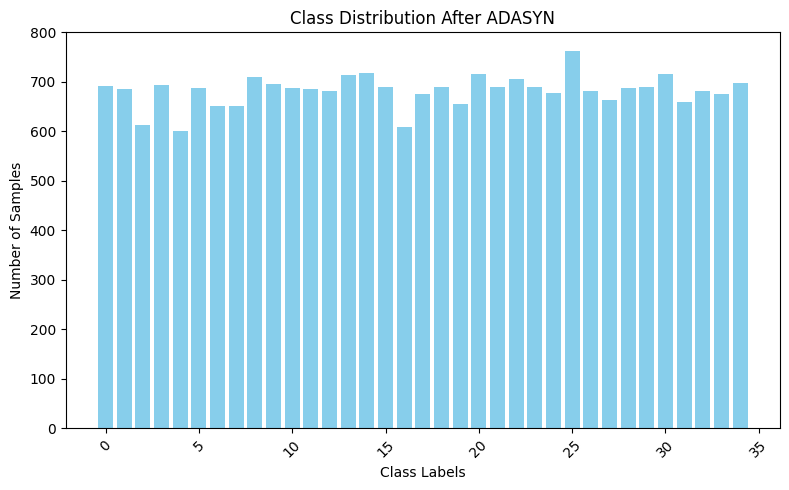


✅ Balanced dataset saved with embeddings in clean array format: Balanced_Embeddings_6180.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
from imblearn.over_sampling import ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import ast
import json

embedding_file = "path_to_your_directory" 
df = pd.read_csv(embedding_file)

def extract_embedding(embedding_str):
    try:
        embedding_list = ast.literal_eval(embedding_str)
        if isinstance(embedding_list, list) and all(isinstance(x, (float, int)) for x in embedding_list):
            return np.array(embedding_list, dtype=np.float32)
        else:
            return np.array([])
    except (ValueError, SyntaxError):
        return np.array([])

df['Embedding'] = df['Embedding'].astype(str).apply(extract_embedding)
df = df[df['Embedding'].apply(lambda x: len(x) > 0)]  

X_data = np.vstack(df['Embedding'].values)
y_data = df['PANN_LABEL'].values

X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_tensor.numpy(), y_tensor.numpy())

X_tensor_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor_resampled = torch.tensor(y_resampled, dtype=torch.long)

class_counts = Counter(y_resampled)
print("\n Class Distribution After ADASYN:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After ADASYN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

embeddings_as_list = [row.tolist() if isinstance(row, (np.ndarray, list)) else list(row) for row in X_resampled]
df_resampled = pd.DataFrame({
    'Embedding': [json.dumps(vec) for vec in embeddings_as_list],
    'PANN_LABEL': y_resampled
})

balanced_csv_path = "Balanced_Embeddings_6180.csv"
df_resampled.to_csv(balanced_csv_path, index=False)
print(f"\n Balanced dataset saved with embeddings in clean array format: {balanced_csv_path}")


🔹 Class Distribution Before ADASYN:
Class 30: 66 samples
Class 16: 306 samples
Class 12: 11 samples
Class 33: 22 samples
Class 1: 686 samples
Class 6: 334 samples
Class 14: 362 samples
Class 28: 144 samples
Class 20: 110 samples
Class 10: 256 samples
Class 24: 229 samples
Class 18: 66 samples
Class 15: 347 samples
Class 22: 239 samples
Class 4: 302 samples
Class 17: 22 samples
Class 5: 11 samples
Class 3: 465 samples
Class 19: 330 samples
Class 23: 11 samples
Class 25: 291 samples
Class 21: 33 samples
Class 26: 33 samples
Class 29: 11 samples
Class 34: 249 samples
Class 31: 75 samples
Class 32: 11 samples
Class 27: 168 samples
Class 13: 106 samples
Class 2: 214 samples
Class 7: 101 samples
Class 8: 157 samples
Class 9: 376 samples
Class 0: 26 samples
Class 11: 10 samples

🔹 Class Distribution After ADASYN:
Class 30: 716 samples
Class 16: 608 samples
Class 12: 682 samples
Class 33: 676 samples
Class 1: 686 samples
Class 6: 652 samples
Class 14: 718 samples
Class 28: 688 samples
Class 2

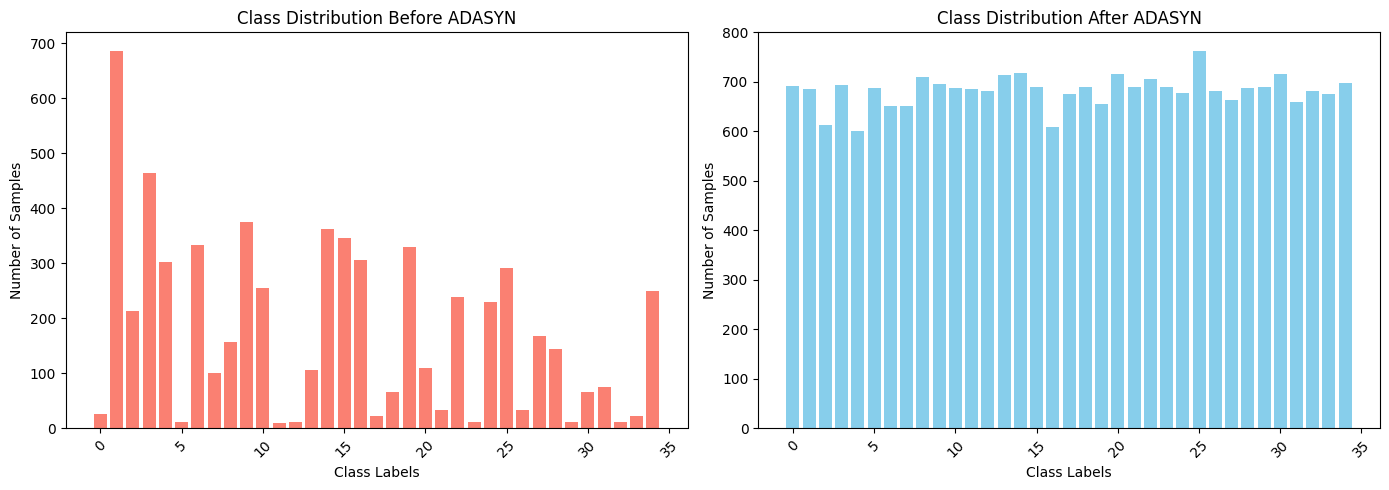

In [ ]:
import pandas as pd
import numpy as np
import torch
from imblearn.over_sampling import ADASYN
from collections import Counter
import matplotlib.pyplot as plt
import ast
import json

embedding_file = "path_to_your_directory"  
df = pd.read_csv(embedding_file)

def extract_embedding(embedding_str):
    try:
        embedding_list = ast.literal_eval(embedding_str)
        if isinstance(embedding_list, list) and all(isinstance(x, (float, int)) for x in embedding_list):
            return np.array(embedding_list, dtype=np.float32)
        else:
            return np.array([])
    except (ValueError, SyntaxError):
        return np.array([])

df['Embedding'] = df['Embedding'].astype(str).apply(extract_embedding)
df = df[df['Embedding'].apply(lambda x: len(x) > 0)]  

X_data = np.vstack(df['Embedding'].values)
y_data = df['PANN_LABEL'].values

X_tensor = torch.tensor(X_data, dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)

original_class_counts = Counter(y_data)
print("\n Class Distribution Before ADASYN:")
for label, count in original_class_counts.items():
    print(f"Class {label}: {count} samples")

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_tensor.numpy(), y_tensor.numpy())

X_tensor_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor_resampled = torch.tensor(y_resampled, dtype=torch.long)

class_counts = Counter(y_resampled)
print("\n Class Distribution After ADASYN:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(original_class_counts.keys(), original_class_counts.values(), color='salmon')
axes[0].set_title("Class Distribution Before ADASYN")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Samples")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(class_counts.keys(), class_counts.values(), color='skyblue')
axes[1].set_title("Class Distribution After ADASYN")
axes[1].set_xlabel("Class Labels")
axes[1].set_ylabel("Number of Samples")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

embeddings_as_list = [row.tolist() if isinstance(row, (np.ndarray, list)) else list(row) for row in X_resampled]
df_resampled = pd.DataFrame({
    'Embedding': [json.dumps(vec) for vec in embeddings_as_list],
    'PANN_LABEL': y_resampled
})

balanced_csv_path = "Balanced_Embeddings_6180.csv"
df_resampled.to_csv(balanced_csv_path, index=False)

In [ ]:
import pandas as pd
df=pd.read_csv("path_to_your_directory")
print(df.head(5))

                                              Embedding  PANN_LABEL
0     [0.003187788650393486, -0.15657174587249756, 0...          30
1     [0.02307325042784214, -0.20973792672157288, 0....          30
2     [0.07079549133777618, -0.006360142026096582, -...          30
3     [-0.43525683879852295, -0.17306075990200043, 0...          30
4     [-0.22946028411388397, -0.17191390693187714, 0...          30
...                                                 ...         ...
6175  [0.25718262791633606, -0.22870977222919464, 0....           1
6176  [0.007357856258749962, -0.32802674174308777, 0...           1
6177  [0.0440870001912117, -0.25284549593925476, -0....           1
6178  [0.20478780567646027, -0.39287689328193665, 0....           1
6179  [0.05128477141261101, -0.12926515936851501, 0....           1

[6180 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("path_to_your_directory") 

df = df.sample(frac=1, random_state=42).reset_index(drop=True) 
train_size = int(0.6 * len(df))  
val_size = int(0.2 * len(df))    
test_size = len(df) - train_size - val_size  

train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

train_df.to_csv("train_dataset.csv", index=False)
val_df.to_csv("validation_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print("Datasets split and saved successfully!")
print(f" Total samples: {len(df)}")
print(f" Train set     : {len(train_df)} samples")
print(f" Validation set: {len(val_df)} samples")
print(f" Test set      : {len(test_df)} samples")


Datasets split and saved successfully!
🔹 Total samples: 23878
✅ Train set     : 14326 samples
✅ Validation set: 4775 samples
✅ Test set      : 4777 samples


In [ ]:
import pandas as pd

df = pd.read_csv("path_to_your_directory")

unique_labels = df['PANN_LABEL'].unique()
print("Unique PANN_LABELs:")
print(unique_labels)

print("\nTotal number of unique PANN_LABELs:", len(unique_labels))

🔸 Unique PANN_LABELs:
[17  5 16 27 24 33  7 12 30 18  3 14 20 29 10 19 21 15  9 34 26  8 23 31
 28  6 22 13  1 32  0 11 25  4  2]

🔸 Total number of unique PANN_LABELs: 35


In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import joblib

np.random.seed(42)

train_file = "path_to_your_directory"
val_file = "path_to_your_directory"
test_file = "path_to_your_directory"

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Embedding'] = df['Embedding'].apply(ast.literal_eval)
    X_data = np.array(df['Embedding'].tolist(), dtype=np.float32)
    y_data = df['PANN_LABEL'].values
    return X_data, y_data

X_train, y_train = load_data(train_file)
X_val, y_val = load_data(val_file)
X_test, y_test = load_data(test_file)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_norm, y_train_enc)

    print(" Validation Results:")
    val_preds = model.predict(X_val_norm)
    print(classification_report(y_val_enc, val_preds, zero_division=0))

    print(" Test Results:")
    test_preds = model.predict(X_test_norm)
    print(classification_report(y_test_enc, test_preds, zero_division=0))

    acc = accuracy_score(y_test_enc, test_preds)
    prec = precision_score(y_test_enc, test_preds, average='weighted', zero_division=0)
    rec = recall_score(y_test_enc, test_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test_enc, test_preds, average='weighted', zero_division=0)

    print(f" Overall Test Accuracy:  {acc:.4f}")
    print(f" Overall Precision:      {prec:.4f}")
    print(f" Overall Recall:         {rec:.4f}")
    print(f" Overall F1-Score:       {f1:.4f}")

    print(" Confusion Matrix (Test):")
    print(confusion_matrix(y_test_enc, test_preds))

    model_filename = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, model_filename)
    print(f" Saved model to {model_filename}")


🚀 Training Logistic Regression...
🔍 Validation Results:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       133
           1       0.28      0.15      0.20       141
           2       0.74      0.84      0.79       113
           3       0.53      0.41      0.47       155
           4       0.64      0.61      0.62        99
           5       1.00      1.00      1.00       148
           6       0.66      0.58      0.62       132
           7       0.87      0.94      0.91       152
           8       0.76      0.93      0.84       150
           9       0.77      0.72      0.74       140
          10       0.72      0.64      0.68       135
          11       1.00      1.00      1.00       123
          12       1.00      1.00      1.00       138
          13       0.91      0.98      0.95       131
          14       0.60      0.58      0.59       147
          15       0.63      0.56      0.59       141
          16       0.68 

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import joblib


np.random.seed(42)

train_file = "path_to_your_directory"
val_file = "path_to_your_directory"
test_file = "path_to_your_directory"

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Embedding'] = df['Embedding'].apply(ast.literal_eval)
    X_data = np.array(df['Embedding'].tolist(), dtype=np.float32)
    y_data = df['PANN_LABEL'].values
    return X_data, y_data

X_train, y_train = load_data(train_file)
X_val, y_val = load_data(val_file)
X_test, y_test = load_data(test_file)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

models = {
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_norm, y_train_enc)

    print(" Validation Results:")
    val_preds = model.predict(X_val_norm)
    print(classification_report(y_val_enc, val_preds, zero_division=0))

    print(" Test Results:")
    test_preds = model.predict(X_test_norm)
    print(classification_report(y_test_enc, test_preds, zero_division=0))

    acc = accuracy_score(y_test_enc, test_preds)
    prec = precision_score(y_test_enc, test_preds, average='weighted', zero_division=0)
    rec = recall_score(y_test_enc, test_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test_enc, test_preds, average='weighted', zero_division=0)

    print(f"Overall Test Accuracy:  {acc:.4f}")
    print(f"Overall Precision:      {prec:.4f}")
    print(f"Overall Recall:         {rec:.4f}")
    print(f" Overall F1-Score:       {f1:.4f}")

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test_enc, test_preds))

    model_filename = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, model_filename)
    print(f" Saved model to {model_filename}")


🚀 Training SVM (RBF Kernel)...
🔍 Validation Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       0.33      0.51      0.40       141
           2       0.91      0.84      0.88       113
           3       0.50      0.51      0.50       155
           4       0.66      0.64      0.65        99
           5       1.00      1.00      1.00       148
           6       0.76      0.68      0.72       132
           7       0.98      0.97      0.97       152
           8       0.92      0.90      0.91       150
           9       0.74      0.79      0.77       140
          10       0.78      0.76      0.77       135
          11       1.00      1.00      1.00       123
          12       1.00      1.00      1.00       138
          13       0.95      0.98      0.97       131
          14       0.63      0.57      0.60       147
          15       0.74      0.67      0.70       141
          16       0.76    

In [ ]:
import pandas as pd
import numpy as np
import ast
import cuml
import cupy as cp
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Embedding'] = df['Embedding'].apply(ast.literal_eval)
    X_data = np.array(df['Embedding'].tolist(), dtype=np.float32)
    y_data = df['PANN_LABEL'].values
    return X_data, y_data

train_file = "path_to_your_directory"
val_file = "path_to_your_directory"
test_file = "path_to_your_directory"


X_train, y_train = load_data(train_file)
X_val, y_val = load_data(val_file)
X_test, y_test = load_data(test_file)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_gpu = cp.array(X_train_scaled, dtype=cp.float32)
X_val_gpu = cp.array(X_val_scaled, dtype=cp.float32)
X_test_gpu = cp.array(X_test_scaled, dtype=cp.float32)
y_train_gpu = cp.array(y_train, dtype=cp.int32)
y_val_gpu = cp.array(y_val, dtype=cp.int32)
y_test_gpu = cp.array(y_test, dtype=cp.int32)

C = 100
kernel = 'poly'  # or 'linear'
gamma = 'auto'  # or 'auto'

print(f"Training SVM with C={C}, kernel={kernel}, gamma={gamma}")
model = cuSVC(C=C, kernel=kernel, gamma=gamma)

try:
    model.fit(X_train_gpu, y_train_gpu)
except Exception as e:
    print(f"Error during model fitting: {e}")

y_val_pred = model.predict(X_val_gpu)
val_accuracy = accuracy_score(y_val_gpu, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = model.predict(X_test_gpu)
test_accuracy = accuracy_score(y_test_gpu, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Training SVM with C=100, kernel=poly, gamma=auto
Validation Accuracy: 0.9104
Test Accuracy: 0.9052


In [ ]:
from sklearn.metrics import precision_recall_fscore_support


y_val_pred = model.predict(X_val_gpu)
val_accuracy = accuracy_score(y_val_gpu, y_val_pred)
y_val_true_np = cp.asnumpy(y_val_gpu)
y_val_pred_np = cp.asnumpy(y_val_pred)
precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
    y_val_true_np, y_val_pred_np, average='weighted'
)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")

y_test_pred = model.predict(X_test_gpu)
test_accuracy = accuracy_score(y_test_gpu, y_test_pred)
y_test_true_np = cp.asnumpy(y_test_gpu)
y_test_pred_np = cp.asnumpy(y_test_pred)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(
    y_test_true_np, y_test_pred_np, average='weighted'
)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import ast
import cuml
import cupy as cp
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
import joblib


def load_data(file_path):
    df = pd.read_csv(file_path)
    df['Embedding'] = df['Embedding'].apply(ast.literal_eval) 
    X_data = np.array(df['Embedding'].tolist(), dtype=np.float32)  
    y_data = df['PANN_LABEL'].values  
    return X_data, y_data


train_file = "path_to_your_directory"
val_file = "path_to_your_directory"
test_file = "path_to_your_directory"

X_train, y_train = load_data(train_file)
X_val, y_val = load_data(val_file)
X_test, y_test = load_data(test_file)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_gpu = cp.array(X_train_scaled, dtype=cp.float32)
X_val_gpu = cp.array(X_val_scaled, dtype=cp.float32)
X_test_gpu = cp.array(X_test_scaled, dtype=cp.float32)
y_train_gpu = cp.array(y_train_encoded, dtype=cp.int32)
y_val_gpu = cp.array(y_val_encoded, dtype=cp.int32)
y_test_gpu = cp.array(y_test_encoded, dtype=cp.int32)

C = 100
kernel = 'poly'  
gamma = 'auto' 

print(f"Training SVM with C={C}, kernel={kernel}, gamma={gamma}")
model = cuSVC(C=C, kernel=kernel, gamma=gamma)

try:
    model.fit(X_train_gpu, y_train_gpu)
except Exception as e:
    print(f"Error during model fitting: {e}")

y_val_pred = model.predict(X_val_gpu)
val_accuracy = accuracy_score(y_val_gpu, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

y_test_pred = model.predict(X_test_gpu)
test_accuracy = accuracy_score(y_test_gpu, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

y_val_true_np = cp.asnumpy(y_val_gpu)
y_val_pred_np = cp.asnumpy(y_val_pred)
precision_val, recall_val, f1_val, _ = precision_recall_fscore_support(
    y_val_true_np, y_val_pred_np, average='weighted'
)
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")

y_test_true_np = cp.asnumpy(y_test_gpu)
y_test_pred_np = cp.asnumpy(y_test_pred)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(
    y_test_true_np, y_test_pred_np, average='weighted'
)
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")

joblib.dump(model, 'svm_cuml_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Model, scaler, and label encoder saved successfully.")



In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import joblib
import cupy as cp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
bert_model = BertModel.from_pretrained(MODEL_NAME)
bert_model.to(device)
bert_model.eval()

svm_model = joblib.load("svm_cuml_model.joblib")
scaler = joblib.load("scaler.joblib")
label_encoder = joblib.load("label_encoder.pkl")
reverse_mapping = {v: k for k, v in enumerate(label_encoder.classes_)}

unlabeled_df = pd.read_excel("path_to_your_directory")

def preprocess_text(text):
    if pd.isna(text): return ""
    text = str(text).strip()
    text = re.sub(r"[^ஂ-ஃஅ-஺ா-ூெ-ைொ-்0-9 ]", "", text) 
    return re.sub(r"\s+", " ", text)

unlabeled_df["clean_song"] = unlabeled_df["song"].apply(preprocess_text)

def get_avg_bert_embedding(text):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=50, return_tensors="pt")
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        outputs = bert_model(**tokens)
    mask = tokens["attention_mask"].squeeze(0).bool()
    embedding = outputs.last_hidden_state.squeeze(0)[mask].mean(dim=0).cpu().numpy()
    return embedding.tolist()

print("\n⏳ Generating embeddings for unlabeled songs...")
unlabeled_embeddings = [get_avg_bert_embedding(text) for text in tqdm(unlabeled_df["clean_song"])]
X_unlabeled = np.array(unlabeled_embeddings, dtype=np.float32)

X_unlabeled_scaled = scaler.transform(X_unlabeled)
X_unlabeled_gpu = cp.array(X_unlabeled_scaled, dtype=cp.float32)
y_unlabeled_pred_gpu = svm_model.predict(X_unlabeled_gpu)
y_unlabeled_pred = cp.asnumpy(y_unlabeled_pred_gpu)

expected_labels = set(range(35)) 

unlabeled_df["PREDICTED_PANN"] = [
    reverse_mapping[pred] if pred in reverse_mapping and pred in expected_labels else "No PANN"
    for pred in y_unlabeled_pred
]

unlabeled_df.to_excel("predicted_unlabeled_songs.xlsx", index=False)

print("\n Predictions saved to 'predicted_unlabeled_songs.xlsx'")

